# Amazon SageMaker with XGBoost and Hyperparameter Tuning for Direct Marketing predictions 
_**Supervised Learning with Gradient Boosted Trees: A Binary Prediction Problem With Unbalanced Classes**_

---

---

## Contents

1. [Objective](#Objective)
1. [Background](#Background-(Problem-Description-and-Approach))
1. [Prepare our Environment](#Prepare-our-Environment)
1. [Download and Explore the Data](#Download-and-Explore-the-Data)
1. [Transform the Data](#Transform-the-Data)
1. [Understand the Algorithm](#Understand-the-Algorithm)
1. [Upload the Input Data to S3](#Upload-the-Input-Data-to-S3)
1. [Train the Model](#Train-the-Model)
1. [Deploy and Evaluate the Model](#Deploy-and-Evaluate-the-Model)
1. [Hyperparameter Optimization (HPO)](#Hyperparameter-Optimization-(HPO))
1. [Conclusions](#Conclusions)
1. [Releasing Cloud Resources](#Releasing-Cloud-Resources)


---

## Objective

This workshop aims to give you an **example of using and tuning a SageMaker built-in algorithm**: Focussing on the **data interfaces** and SageMaker's automatic **Hyperparameter Optimization** (HPO) capabilities.

Teaching in-depth data science approaches for tabular data is outside this scope, and we hope you can use this notebook as a starting point to modify for the needs of your future projects.

---

## Background (Problem Description and Approach)

- **Direct marketing**: contacting potential new customers via mail, email, phone call etc. 
- **Challenge**: A) too many potential customers. B) limited resources of the approacher (time, money etc.).
- **Problem: Which are the potential customers with the higher chance of becoming actual customers**? (so as to focus the effort only on them). 
- **Our setting**: A bank who wants to predict *whether a customer will enroll for a term deposit, after one or more phone calls*.
- **Our approach**: Build a ML model to do this prediction, from readily available information e.g. demographics, past interactions etc. (features).
- **Our tools**: We will be using the **XGBoost** algorithm implementation by **Amazon SageMaker**, and using SageMaker **Hyperparameter Optimization (HPO)** to improve our model.


---

## Prepare our Environment

We'll need to:

- **import** some useful libraries (as in any Python notebook)
- **configure** the S3 bucket and folder where data should be stored (to keep our environment tidy)
- **connect** to AWS in general (with [boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html)) and SageMaker in particular (with the [sagemaker SDK](https://sagemaker.readthedocs.io/en/stable/)), to use the cloud services

While `boto3` is the general AWS SDK for Python, `sagemaker` provides some powerful, higher-level interfaces designed specifically for ML workflows.


In [1]:
!pip install matplotlib

In [2]:
import numpy as np  # For matrix operations and numerical processing
import pandas as pd  # For munging tabular data
import time
import os
from util.classification_report import generate_classification_report  # helper function for classification reports

# setting up SageMaker parameters
import sagemaker
import boto3

boto_session = boto3.Session()
region = boto_session.region_name
bucket_name = sagemaker.Session().default_bucket()
bucket_prefix = "xgboost-example"  # Location in the bucket to store our files
sgmk_session = sagemaker.Session()
sgmk_client = boto_session.client("sagemaker")
sgmk_role = sagemaker.get_execution_role()

print(sgmk_role)


arn:aws:iam::482414474587:role/service-role/AmazonSageMaker-ExecutionRole-20210910T150166


---

## Download and Explore the Data

Let's start by downloading the [direct marketing dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing) from UCI's ML Repository.

We can run shell commands from inside Jupyter using the `!` prefix:


In [3]:
!wget -P data/ -N https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip

import zipfile
with zipfile.ZipFile("data/bank-additional.zip", 'r') as zip_ref:
    print("Unzipping...")
    zip_ref.extractall("data")
print("Done")

--2021-09-10 07:26:37--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 444572 (434K) [application/x-httpd-php]
Saving to: ‘data/bank-additional.zip’

bank-additional.zip 100%[===================>] 434.15K   445KB/s    in 1.0s    

2021-09-10 07:26:39 (445 KB/s) - ‘data/bank-additional.zip’ saved [444572/444572]

Unzipping...
Done


Now lets read this into a Pandas data frame and take a look.


In [4]:
df_data = pd.read_csv("./data/bank-additional/bank-additional-full.csv", sep=";")

pd.set_option("display.max_columns", 500)  # Make sure we can see all of the columns
df_data.head()  # show part of the dataframe


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


_**Specifics on each of the features:**_

*Demographics:*
* `age`: Customer's age (numeric)
* `job`: Type of job (categorical: 'admin.', 'services', ...)
* `marital`: Marital status (categorical: 'married', 'single', ...)
* `education`: Level of education (categorical: 'basic.4y', 'high.school', ...)

*Past customer events:*
* `default`: Has credit in default? (categorical: 'no', 'unknown', ...)
* `housing`: Has housing loan? (categorical: 'no', 'yes', ...)
* `loan`: Has personal loan? (categorical: 'no', 'yes', ...)

*Past direct marketing contacts:*
* `contact`: Contact communication type (categorical: 'cellular', 'telephone', ...)
* `month`: Last contact month of year (categorical: 'may', 'nov', ...)
* `day_of_week`: Last contact day of the week (categorical: 'mon', 'fri', ...)
* `duration`: Last contact duration, in seconds (numeric). Important note: If duration = 0 then `y` = 'no'.
 
*Campaign information:*
* `campaign`: Number of contacts performed during this campaign and for this client (numeric, includes last contact)
* `pdays`: Number of days that passed by after the client was last contacted from a previous campaign (numeric)
* `previous`: Number of contacts performed before this campaign and for this client (numeric)
* `poutcome`: Outcome of the previous marketing campaign (categorical: 'nonexistent','success', ...)

*External environment factors:*
* `emp.var.rate`: Employment variation rate - quarterly indicator (numeric)
* `cons.price.idx`: Consumer price index - monthly indicator (numeric)
* `cons.conf.idx`: Consumer confidence index - monthly indicator (numeric)
* `euribor3m`: Euribor 3 month rate - daily indicator (numeric)
* `nr.employed`: Number of employees - quarterly indicator (numeric)

*Target variable* **(the one we want to eventually predict):**
* `y`: Has the client subscribed to a term deposit? (binary: 'yes','no')


---

## Transform the Data

Cleaning up data is part of nearly every ML project. Several common steps include:

* **Handling missing values**: In our case there are no missing values.
* **Handling weird/outlier values**: There are some values in the dataset that may require manipulation.
* **Converting categorical to numeric**: There are a lot of categorical variables in our dataset. We need to address this.
* **Oddly distributed data**: We will be using XGBoost, which is a non-linear method, and is minimally affected by the data distribution.
* **Remove unnecessary data**: There are lots of columns representing general economic features that may not be available during inference time.

To summarise, we need to A) address some weird values, B) convert the categorical to numeric valriables and C) Remove unnecessary data:


1. Many records have the value of "999" for `pdays`. It is very likely to be a 'magic' number to represent that *no contact was made before*. Considering that, we will create a new column called "no_previous_contact", then grant it value of "1" when pdays is 999 and "0" otherwise.

2. In the `job` column, there are more than one categories for people who don't work e.g., "student", "retired", and "unemployed". It is very likely the decision to enroll or not to a term deposit depends a lot on whether the customer is working or not. A such, we generate a new column to show whether the customer is working based on `job` column.

3. We will remove the economic features and `duration` from our data as they would need to be forecasted with high precision to be used as features during inference time.

4. We convert categorical variables to numeric using *one hot encoding*.


In [5]:
df_data_raw = df_data.copy()  # keep a version of the original data


In [6]:
# Indicator variable to capture when pdays takes a value of 999
df_data["no_previous_contact"] = np.where(df_data["pdays"] == 999, 1, 0)

# Indicator for individuals not actively employed
df_data["not_working"] = np.where(np.in1d(df_data["job"], ["student", "retired", "unemployed"]), 1, 0)

# remove unnecessary data
df_model_data = df_data.drop(
    ["duration", 
    "emp.var.rate", 
    "cons.price.idx", 
    "cons.conf.idx", 
    "euribor3m", 
    "nr.employed"], 
    axis=1,
)

df_model_data = pd.get_dummies(df_model_data)  # Convert categorical variables to sets of indicators

# Replace "y_no" and "y_yes" with a single label column, and bring it to the front:
df_model_data = pd.concat(
    [
        df_model_data["y_yes"].rename("y"),
        df_model_data.drop(["y_no", "y_yes"], axis=1),
    ],
    axis=1,
)

df_model_data.head()  # show part of the new transformed dataframe (which will be used for training)


,y,age,campaign,pdays,previous,no_previous_contact,not_working,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,0,56,1,999,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
1,0,57,1,999,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
2,0,37,1,999,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
3,0,40,1,999,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
4,0,56,1,999,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0


---

## Understand the Algorithm

We'll be using SageMaker's [built-in **XGBoost Algorithm**](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html): Benefiting from performance-optimized, pre-implemented functionality like multi-instance parallelization, and support for multiple input formats.

In general to use the pre-built algorithms, we'll need to:

- Refer to the [Common Parameters docs](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html) to see the **high-level configuration** and what features each algorithm has
- Refer to the [algorithm docs](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html) to understand the **detail** of the **data formats** and **(hyper)-parameters** it supports

From these docs, we'll understand what data format we need to upload to S3 (next), and how to get the container image URI of the algorithm... which is listed on the Common Parameters page but can also be extracted through the SDK:


In [7]:
# specify container
training_image = sagemaker.image_uris.retrieve("xgboost", region=region, version="1.0-1")

print(training_image)

121021644041.dkr.ecr.ap-southeast-1.amazonaws.com/sagemaker-xgboost:1.0-1-cpu-py3


---

## Upload the Input Data to S3

We know from [the algorithm docs](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html#InputOutput-XGBoost) that SageMaker XGBoost expects data in the **libSVM** or **CSV** formats, with:

- The target variable in the first column, and
- No header row

...So before initializing training, we will:

1. Suffle and split the data into **Training (70%)**, **Validation (20%)**, and **Test (10%)** sets
2. Save the data in the format the algorithm expects (e.g. CSV)
3. Upload the data to S3
4. Define the training job input "channels" with explicit CSV content type tagging, via the SageMaker SDK [TrainingInput](https://sagemaker.readthedocs.io/en/stable/api/utility/inputs.html#sagemaker.inputs.TrainingInput) class

The Training and Validation datasets will be used during the training (and tuning) phase, while the 'holdout' Test set will be used afterwards to evaluate the model.


In [8]:
# Shuffle and splitting dataset
train_data, validation_data, test_data = np.split(
    df_model_data.sample(frac=1, random_state=0), 
    [int(0.7 * len(df_model_data)), int(0.9*len(df_model_data))],
) 

# Create CSV files for Train / Validation / Test
train_data.to_csv("data/train.csv", index=False, header=False)
validation_data.to_csv("data/validation.csv", index=False, header=False)
test_data.to_csv("data/test.csv", index=False, header=False)


In [17]:
# split the original raw data

train_data_raw, test_data_raw = np.split(
    df_data_raw.sample(frac=1, random_state=0), 
    [int(0.9*len(df_data_raw))],
) 


In [18]:
test_data_raw.head(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
1535,39,services,married,high.school,no,yes,no,telephone,may,thu,17,3,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
8498,56,blue-collar,married,basic.9y,unknown,no,no,telephone,jun,wed,99,6,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1,no
15398,24,blue-collar,single,high.school,no,yes,no,cellular,jul,fri,203,1,999,0,nonexistent,1.4,93.918,-42.7,4.957,5228.1,no
8620,53,management,married,university.degree,no,unknown,unknown,telephone,jun,wed,232,1,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1,no
15227,29,unemployed,married,university.degree,no,no,no,cellular,jul,thu,275,2,999,0,nonexistent,1.4,93.918,-42.7,4.958,5228.1,no
9428,51,self-employed,married,university.degree,unknown,no,no,telephone,jun,fri,145,2,999,0,nonexistent,1.4,94.465,-41.8,4.967,5228.1,no
37729,34,technician,single,unknown,no,yes,no,cellular,aug,thu,320,2,3,1,success,-2.9,92.201,-31.4,0.851,5076.2,yes
17111,52,admin.,married,high.school,no,no,no,cellular,jul,fri,324,1,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
18922,37,technician,single,professional.course,no,yes,no,cellular,aug,mon,44,1,999,0,nonexistent,1.4,93.444,-36.1,4.970,5228.1,no
23901,50,management,married,university.degree,no,no,no,cellular,aug,fri,299,2,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,no


In [19]:
test_data.head(10)

,y,age,campaign,pdays,previous,no_previous_contact,not_working,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
1535,0,39,3,999,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0
8498,0,56,6,999,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0
15398,0,24,1,999,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
8620,0,53,1,999,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0
15227,0,29,2,999,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
9428,0,51,2,999,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
37729,1,34,2,3,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
17111,0,52,1,999,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
18922,0,37,1,999,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
23901,0,50,2,999,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0


In [20]:
train_data_raw.head(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
15500,39,blue-collar,married,basic.9y,no,yes,no,cellular,jul,fri,635,3,999,0,nonexistent,1.4,93.918,-42.7,4.957,5228.1,yes
29034,55,blue-collar,married,basic.4y,no,yes,no,cellular,apr,fri,248,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,no
11199,39,blue-collar,married,basic.9y,unknown,no,no,telephone,jun,thu,207,1,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1,no
22247,56,self-employed,married,basic.9y,no,yes,no,cellular,aug,thu,176,7,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,no
27180,49,blue-collar,married,basic.9y,no,yes,no,cellular,nov,fri,271,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,no
33831,43,blue-collar,married,basic.4y,no,no,yes,cellular,may,wed,589,1,999,0,nonexistent,-1.8,92.893,-46.2,1.281,5099.1,no
961,58,unknown,married,unknown,unknown,no,no,telephone,may,wed,118,3,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,no
10746,28,services,single,high.school,no,no,no,telephone,jun,tue,406,3,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1,no
15195,24,technician,single,basic.6y,no,yes,no,telephone,jul,thu,1448,7,999,0,nonexistent,1.4,93.918,-42.7,4.958,5228.1,yes
34319,34,admin.,married,high.school,no,no,no,cellular,may,thu,362,1,999,1,failure,-1.8,92.893,-46.2,1.266,5099.1,no


In [21]:
train_data.head(10)

,y,age,campaign,pdays,previous,no_previous_contact,not_working,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
15500,1,39,3,999,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
29034,0,55,2,999,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
11199,0,39,1,999,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
22247,0,56,7,999,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
27180,0,49,1,999,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
33831,0,43,1,999,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
961,0,58,3,999,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
10746,0,28,3,999,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0
15195,1,24,7,999,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
34319,0,34,1,999,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0


In [9]:
# Upload CSV files to S3 for SageMaker training
train_uri = sgmk_session.upload_data(
    path="data/train.csv",
    bucket=bucket_name,
    key_prefix=bucket_prefix,
)
val_uri = sgmk_session.upload_data(
    path="data/validation.csv",
    bucket=bucket_name,
    key_prefix=bucket_prefix,
)


# Define the data input channels for the training job:
s3_input_train = sagemaker.inputs.TrainingInput(train_uri, content_type="csv")
s3_input_validation = sagemaker.inputs.TrainingInput(val_uri, content_type="csv")

print(f"{s3_input_train.config}\n\n{s3_input_validation.config}")

{'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix', 'S3Uri': 's3://sagemaker-ap-southeast-1-482414474587/xgboost-example/train.csv', 'S3DataDistributionType': 'FullyReplicated'}}, 'ContentType': 'csv'}

{'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix', 'S3Uri': 's3://sagemaker-ap-southeast-1-482414474587/xgboost-example/validation.csv', 'S3DataDistributionType': 'FullyReplicated'}}, 'ContentType': 'csv'}


---

## Train the Model

Training a model on SageMaker follows the usual steps with other ML libraries (e.g. SciKit-Learn):
1. Initiate a session (we did this up top).
2. Instantiate an estimator object for our algorithm (XGBoost).
3. Define its hyperparameters.
4. Start the training job.

#### A small competition!
SageMaker's XGBoost includes 38 parameters. You can find more information about them [here](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html).
For simplicity, we choose to experiment only with a few of them.

**Please select values for the 4 hyperparameters (by replacing the ?) based on the provided ranges.** Later we will see which model performed best and compare it with the one from the Hyperparameter Optimization step.


In [11]:
# Instantiate an XGBoost estimator object
estimator = sagemaker.estimator.Estimator(
    image_uri=training_image,      # XGBoost algorithm container
    instance_type="ml.m5.xlarge",  # type of training instance
    instance_count=1,              # number of instances to be used
    role=sgmk_role,                # IAM role to be used
    max_run=20*60,                 # Maximum allowed active runtime
    use_spot_instances=True,       # Use spot instances to reduce cost
    max_wait=30*60,                # Maximum clock time (including spot delays)
)

# scale_pos_weight is a paramater that controls the relative weights of the classes.
# Because the data set is so highly skewed, we set this parameter according to the ratio (n/y)
scale_pos_weight = np.count_nonzero(train_data["y"].values==0) / np.count_nonzero(train_data["y"].values)

# define its hyperparameters
estimator.set_hyperparameters(
    num_round=150,     # int: [1,300]
    max_depth=3,     # int: [1,10]
    alpha=2.5,         # float: [0,5]
    eta=0.5,           # float: [0,1]
    objective="binary:logistic",
    scale_pos_weight=scale_pos_weight,  # set the balance between the 2 classes
)

# start a training (fitting) job
estimator.fit({ "train": s3_input_train, "validation": s3_input_validation })


2021-09-10 07:31:31 Starting - Starting the training job...
2021-09-10 07:31:33 Starting - Launching requested ML instancesProfilerReport-1631259091: InProgress
...
2021-09-10 07:32:24 Starting - Preparing the instances for training............
2021-09-10 07:34:26 Downloading - Downloading input data
2021-09-10 07:34:26 Training - Downloading the training image..
2021-09-10 07:35:02 Uploading - Uploading generated training model
2021-09-10 07:35:02 Completed - Training job completed
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input 

---

## Deploy and Evaluate the Model

### Deployment

Now that we've trained the xgboost algorithm on our data, deploying the model (hosting it behind a real-time endpoint) is just one function call!

This deployment might take **up to 10 minutes**, and by default the code will wait for the deployment to complete.

If you like, you can instead:

- Un-comment the `wait=False` parameter
- Use the [Endpoints page of the SageMaker Console](https://console.aws.amazon.com/sagemaker/home?#/endpoints) to check the status of the deployment
- Skip over the *Evaluation* section below (which won't run until the deployment is complete), and start the Hyperparameter Optimization job - which will take a while to run too, so can be started in parallel


In [12]:
# Real-time endpoint:
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large",
    # wait=False,  # Remember, predictor.predict() won't work until deployment finishes!
)


------!

### Evaluation

Since SageMaker is a general purpose ML platform and our endpoint is a web service, we'll need to be explicit that we're sending in tabular data (_serialized_ in CSV string format for the HTTPS request) and expect a tabular response (to be _deserialized_ from CSV to numpy).

In the SageMaker SDK (from v2), this packing and unpacking of the payload for the web endpoint is handled by [serializer classes](https://sagemaker.readthedocs.io/en/stable/api/inference/serializers.html) and [deserializer classes](https://sagemaker.readthedocs.io/en/stable/api/inference/deserializers.html).

Unfortunately the pre-built `CSVDeserializer` produces nested Python lists of strings, rather than a numpy array of numbers - so rather than bothering to implement a custom class (like the examples [here](https://github.com/aws/sagemaker-python-sdk/blob/master/src/sagemaker/deserializers.py)) we'll be lazy and take this as a post-processing step.

With this setup ready, requesting inferences is as easy as calling `predictor.predict()`:

In [13]:
predictor.serializer = sagemaker.serializers.CSVSerializer()
predictor.deserializer = sagemaker.deserializers.CSVDeserializer()

In [14]:
X_test_numpy = test_data.drop(["y"], axis=1).values

predictions = np.array(predictor.predict(X_test_numpy), dtype=float).squeeze()
predictions

array([0.17046733, 0.28514871, 0.46938035, ..., 0.83710849, 0.20421937,
       0.28138947])

Each number in this vector is the **predicted probability** (in the interval [0,1]) of a potential customer enrolling for a term deposit.

- 0: The person **will not** enroll
- 1: The person **will** enroll (making them a good candidate for direct marketing)

If we like, we could stitch these predictions back on to the original dataframe to explore performance:


In [15]:
test_results = pd.concat(
    [
        pd.Series(predictions, name="y_pred", index=test_data.index),
        test_data,
    ],
    axis=1
)
test_results.head()


,y_pred,y,age,campaign,pdays,previous,no_previous_contact,not_working,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
1535,0.170467,0,39,3,999,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0
8498,0.285149,0,56,6,999,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0
15398,0.469380,0,24,1,999,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
8620,0.216798,0,53,1,999,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0
15227,0.495048,0,29,2,999,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0


...Or use this function we provided to generate a more **comprehensive model report**:


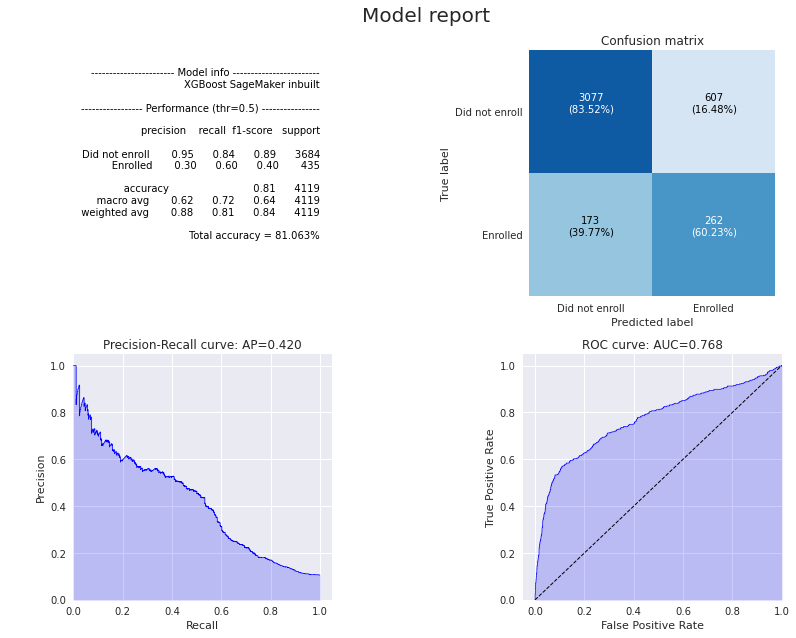

In [16]:
generate_classification_report(
    y_actual=test_data["y"].values, 
    y_predict_proba=predictions, 
    decision_threshold=0.5,
    class_names_list=["Did not enroll","Enrolled"],
    model_info="XGBoost SageMaker inbuilt",
)


---

## Autogluon

In [22]:
# Upgrade pip to ensure the latest package versions are available
!pip install -U pip
# Upgrade setuptools to be compatible with namespace packages
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0"
# Install autogluon (Tutorial based on autogluon==0.3.0)
!pip install autogluon

In [23]:
from autogluon.tabular import TabularPredictor


In [24]:
# Now lets use the 'best_quality' preset and leverage the SOTA multi-layer stacking functionality in AutoGluon
# This will take ~20x as long as the normal training run, so it is generally a good practice to only use 'best_quality' when you want the absolute best models.

predictor_best = TabularPredictor(label='y').fit(train_data_raw, presets='best_quality', excluded_model_types=['NN', 'FASTAI'])
performance = predictor_best.evaluate(test_data_raw)


No path specified. Models will be saved in: "AutogluonModels/ag-20210910_074922/"
Presets specified: ['best_quality']
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20210910_074922/"
AutoGluon Version:  0.3.1
Train Data Rows:    37069
Train Data Columns: 20
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  ['yes', 'no']
	If 'binary' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = yes, class 0 = no
	Note: For your binary classification, AutoGluon arbitrarily selected which label-value represents positive (yes) vs negative (no) class.
	To explicitly set the positive_class, either rename classes to 1 and 0, or specify positive_class in Predictor init.
Using Feature Generators to preproc

In [29]:
# Get prediction probabilities
out_autogluon = predictor_best.predict_proba(test_data_raw)
out_autogluon.head(10)

,no,yes
1535,0.989095,0.010905
8498,0.989095,0.010905
15398,0.989090,0.010910
8620,0.989090,0.010910
15227,0.988624,0.011376
9428,0.989095,0.010905
37729,0.309453,0.690547
17111,0.987070,0.012930
18922,0.989095,0.010905
23901,0.987300,0.012700


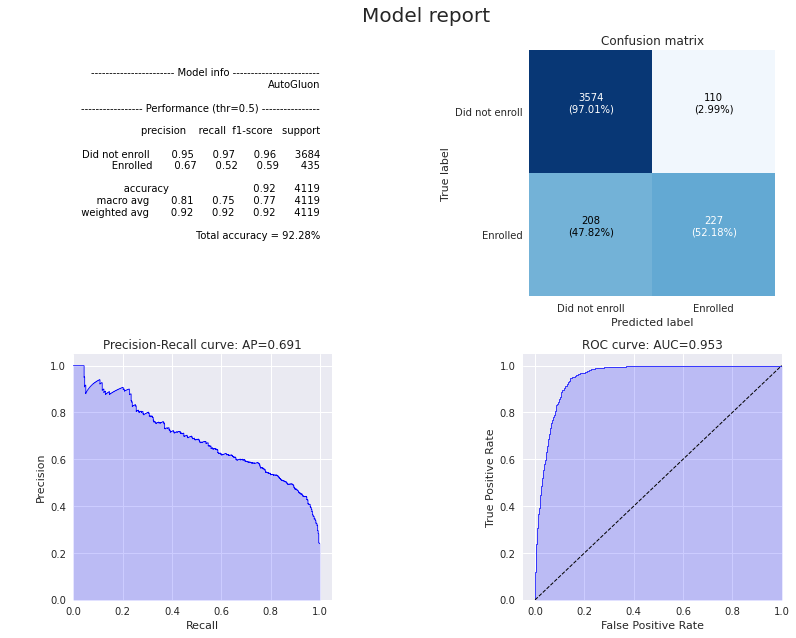

In [32]:
generate_classification_report(
    y_actual=test_data["y"].values, 
    y_predict_proba=out_autogluon['yes'].values, 
    decision_threshold=0.5,
    class_names_list=["Did not enroll","Enrolled"],
    model_info="AutoGluon",
)


In [36]:
# Get feature importance
predictor_best.feature_importance(test_data_raw, subsample_size=None, time_limit=60)

Computing feature importance via permutation shuffling for 20 features using 4119 rows with 10 shuffle sets... Time limit: 60s...
	643.02s	= Expected runtime (64.3s per shuffle set)
	48.98s	= Actual runtime (Completed 2 of 10 shuffle sets) (Early stopping due to lack of time...)


,importance,stddev,p_value,n,p99_high,p99_low
duration,0.045521,0.002232,0.011030,2,0.145974,-0.054933
euribor3m,0.010804,0.000172,0.003576,2,0.018531,0.003076
nr.employed,0.008254,0.000000,0.500000,2,0.008254,0.008254
pdays,0.001578,0.000515,0.072192,2,0.024760,-0.021604
emp.var.rate,0.000971,0.000687,0.147584,2,0.031880,-0.029938
contact,0.000971,0.002060,0.312833,2,0.093698,-0.091755
month,0.000486,0.000687,0.250000,2,0.031394,-0.030423
previous,0.000121,0.000172,0.250000,2,0.007849,-0.007606
default,0.000000,0.000687,0.500000,2,0.030909,-0.030909
housing,-0.000121,0.000858,0.562833,2,0.038515,-0.038757


---

## Hyperparameter Optimization (HPO)
*Note, with the default settings below, the hyperparameter tuning job can take up to ~20 minutes to complete.*

We will use SageMaker HyperParameter Optimization (HPO) to automate the searching process effectively. Specifically, we **specify a range**, or a list of possible values in the case of categorical hyperparameters, for each of the hyperparameter that we plan to tune.

SageMaker hyperparameter tuning will automatically launch **multiple training jobs** with different hyperparameter settings, evaluate results of those training jobs based on a predefined "objective metric", and select the hyperparameter settings for future attempts based on previous results. For each hyperparameter tuning job, we will specify the maximum number of HPO tries (`max_jobs`) and how many of these can happen in parallel (`max_parallel_jobs`).

Tip: `max_parallel_jobs` creates a **trade-off between performance and speed** (better hyperparameter values vs how long it takes to find these values). If `max_parallel_jobs` is large, then HPO is faster, but the discovered values may not be optimal. Smaller `max_parallel_jobs` will increase the chance of finding optimal values, but HPO will take more time to finish.

Next we'll specify the objective metric that we'd like to tune and its definition, which includes the regular expression (Regex) needed to extract that metric from the CloudWatch logs of the training job. Since we are using built-in XGBoost algorithm here, it emits two predefined metrics: **validation:auc** and **train:auc**, and we elected to monitor *validation:auc* as you can see below. In this case (because it's pre-built for us), we only need to specify the metric name.

For more information on the documentation of the Sagemaker HPO please refer [here](https://sagemaker.readthedocs.io/en/stable/tuner.html).

In [34]:
# import required HPO objects
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

# set up hyperparameter ranges
ranges = {
    "num_round": IntegerParameter(1, 300),
    "max_depth": IntegerParameter(1, 10),
    "alpha": ContinuousParameter(0, 5),
    "eta": ContinuousParameter(0, 1),
}

# set up the objective metric
objective = "validation:auc"

# instantiate a HPO object
tuner = HyperparameterTuner(
    estimator=estimator,              # the SageMaker estimator object
    hyperparameter_ranges=ranges,     # the range of hyperparameters
    max_jobs=20,                      # total number of HPO jobs
    max_parallel_jobs=5,              # how many HPO jobs can run in parallel
    strategy="Bayesian",              # the internal optimization strategy of HPO
    objective_metric_name=objective,  # the objective metric to be used for HPO
    objective_type="Maximize",        # maximize or minimize the objective metric
)  


### Launch HPO
Now we can launch a hyperparameter tuning job by calling *fit()* function. After the hyperparameter tuning job is created, we can go to SageMaker console to track the progress of the hyperparameter tuning job until it is completed.

In [37]:
# start HPO
tuner.fit({ "train": s3_input_train, "validation": s3_input_validation })


Defaulting to the only supported framework/algorithm version: latest.
Ignoring unnecessary instance type: None.
Creating hyperparameter tuning job with name: sagemaker-xgboost-210910-0815


.......................................................................................................................................................................................!


HPO jobs often take quite a long time to finish and as such, sometimes you may want to free up the notebook and then resume the wait later.

Just like the Estimator, we won't be able to `deploy()` the model until the HPO tuning job is complete; and the status is visible through both the [AWS Console](https://console.aws.amazon.com/sagemaker/home?#/hyper-tuning-jobs) and the [SageMaker API](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_DescribeHyperParameterTuningJob.html). We could for example write a polling script like the below:

### Deploy and test optimized model
Deploying the best model is another simple `.deploy()` call:

In [38]:
# deploy the best model from HPO
hpo_predictor = tuner.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large",
    serializer=sagemaker.serializers.CSVSerializer(),
    deserializer=sagemaker.deserializers.CSVDeserializer(),
)



2021-09-10 08:23:15 Starting - Preparing the instances for training
2021-09-10 08:23:15 Downloading - Downloading input data
2021-09-10 08:23:15 Training - Training image download completed. Training in progress.
2021-09-10 08:23:15 Uploading - Uploading generated training model
2021-09-10 08:23:15 Completed - Training job completed

Creating model with name: sagemaker-xgboost-2021-09-10-08-31-28-930


Creating endpoint with name sagemaker-xgboost-210910-0815-009-26c24f2c


-------------!

Once deployed, we can now evaluate the performance of the best model.

[0.213557   0.22245082 0.45318586 ... 0.72607833 0.34265494 0.2956591 ]


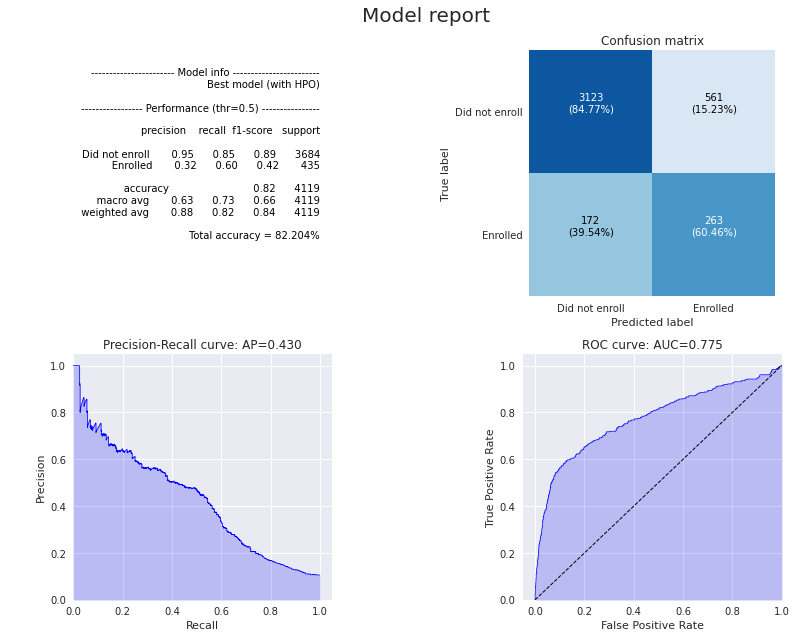

In [39]:
# getting the predicted probabilities of the best model
hpo_predictions = np.array(hpo_predictor.predict(X_test_numpy), dtype=float).squeeze()
print(hpo_predictions)

# generate report for the best model
generate_classification_report(
    y_actual=test_data["y"].values, 
    y_predict_proba=hpo_predictions, 
    decision_threshold=0.5,
    class_names_list=["Did not enroll","Enrolled"],
    model_info="Best model (with HPO)",
)


---

## Conclusions

In our run, the optimized HPO model exhibited an AUC of ~0.774: fairly higher than our first-guess parameter combination!

Depending on the number of tries, HPO can find a better performing model faster, compared to simply trying different hyperparameters by trial and error or grid search. You can learn more in-depth details about SageMaker HPO [here](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning-how-it-works.html).

SageMaker built-in algorithms are great for getting a first model fast, and combining them with SageMaker HPO can really boost their accuracy.

As we mentioned here, the best way to success with a built-in algorithm is to **read the [algorithm's doc pages](https://docs.aws.amazon.com/sagemaker/latest/dg/algos.html) carefully** - to understand what data format and parameters it needs!


---

## Releasing Cloud Resources

It's generally a good practice to deactivate all endpoints which are not in use.  

Please uncomment the following lines and run the cell in order to deactivate the 2 endpoints that were created before. 


In [40]:
predictor.delete_endpoint(delete_endpoint_config=True)
hpo_predictor.delete_endpoint(delete_endpoint_config=True)


Deleting endpoint configuration with name: sagemaker-xgboost-2021-09-10-07-37-14-448
Deleting endpoint with name: sagemaker-xgboost-2021-09-10-07-37-14-448
Deleting endpoint configuration with name: sagemaker-xgboost-210910-0815-009-26c24f2c
Deleting endpoint with name: sagemaker-xgboost-210910-0815-009-26c24f2c
